# Why You Cannot Recover Spikes from Firing Rates

This notebook demonstrates, with a **minimal and fully controlled example**, why the process

> spike train → convolution → firing rate

**cannot be inverted in general**, even when:

- the kernel is perfectly known
- there is no measurement noise
- the forward process is exactly linear

This failure is *not numerical* — it is **fundamental** and lies at the core of firing‑rate and Wilson–Cowan theories.

---

## 1. Setup

We work in continuous time discretized with a small `dt`. All variables are explicitly constructed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 4)

---

## 2. Time axis

In [2]:
dt = 0.1  # ms
t  = np.arange(0, 500, dt)

---

## 3. Ground‑truth spike train

We define a **sparse spike train** as a sum of delta-like events.

In [3]:
S = np.zeros_like(t)
spike_times = np.array([50, 120, 200, 260, 340, 410])  # ms
S[(spike_times / dt).astype(int)] = 1.0 / dt

Plot the spike train:

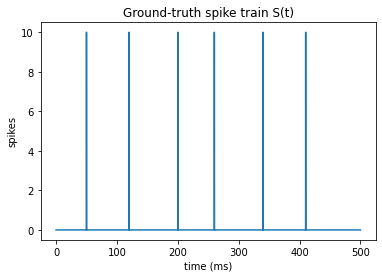

In [4]:
plt.plot(t, S)
plt.title("Ground-truth spike train S(t)")
plt.xlabel("time (ms)")
plt.ylabel("spikes")
plt.show()

---

## 4. Gaussian convolution kernel

This kernel plays the role of a **temporal coarse‑graining window**.

In [5]:
def gaussian_kernel(t, W):
    return np.exp(-0.5 * (t / W)**2) / (np.sqrt(2*np.pi) * W)

W = 10.0  # ms
kt = np.arange(-5*W, 5*W, dt)
K  = gaussian_kernel(kt, W)

Plot the kernel:

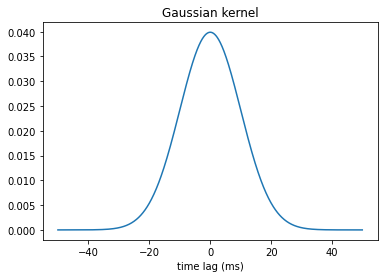

In [6]:
plt.plot(kt, K)
plt.title("Gaussian kernel")
plt.xlabel("time lag (ms)")
plt.show()

---

## 5. Forward process: firing rate generation

We compute the firing rate via convolution:

$
 r(t) = (K * S)(t)
$

In [7]:
r = np.convolve(S, K, mode='same') * dt

Plot rate and spike times together:

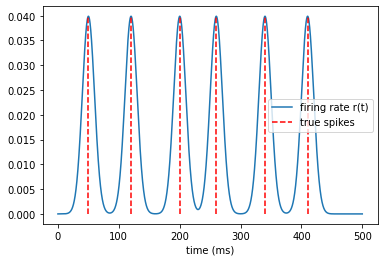

In [8]:
plt.plot(t, r, label='firing rate r(t)')
plt.vlines(spike_times, 0, r.max(),
           colors='r', linestyles='dashed', label='true spikes')
plt.legend()
plt.xlabel("time (ms)")
plt.show()

**Interpretation:** the firing rate is smooth, causal, and carries no explicit spike timing.

---

## 6. Naive deconvolution attempt (Fourier inversion)

In Fourier space:

$
 \hat r(\omega) = \hat K(\omega)\,\hat S(\omega)
$

Formally, one might try:

$
 \hat S = \hat r / \hat K
$

and then inverting the $\hat S$ transform to obtain the spike series $S(t)$

In [9]:
R  = np.fft.fft(r)
Kf = np.fft.fft(K, n=len(r))

eps = 1e-6  # numerical regularization
S_rec = np.real(np.fft.ifft(R / (Kf + eps)))

Plot the reconstructed signal:

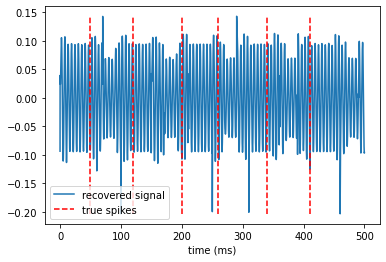

In [10]:
plt.plot(t, S_rec, label='recovered signal')
plt.vlines(spike_times, S_rec.min(), S_rec.max(),
           colors='r', linestyles='dashed', label='true spikes')
plt.legend()
plt.xlabel("time (ms)")
plt.show()

---

## 7. What goes wrong?

You should observe:

- oscillatory ringing
- negative lobes
- spurious peaks
- poor alignment with true spikes

This happens **even though**:

- there is no noise
- the kernel is known exactly
- the forward operation is linear

---

## 8. Frequency‑domain explanation

The Fourier transform of a Gaussian is also a Gaussian:

$
 \hat K(\omega) = e^{-\omega^2 W^2 / 2}
$

So at high frequencies:

$
 \hat K(\omega) \to 0
$

Dividing by it **amplifies numerical and discretization errors without bound**.

Spike trains are **not band‑limited**, so the information is gone.

---

## 9. Non‑uniqueness: two spike trains, same rate

We now construct a *different* spike train with slightly shifted spikes.

In [11]:
S2 = np.zeros_like(t)
spike_times2 = spike_times + np.array([2, -3, 1, -2, 3, -1])
S2[(spike_times2 / dt).astype(int)] = 1.0 / dt

r2 = np.convolve(S2, K, mode='same') * dt



S3 = np.zeros_like(t)
spike_times3 = spike_times + 20*np.array([2, -3, 1, -2, 3, -1])
S3[(spike_times3 / dt).astype(int)] = 1.0 / dt

r3 = np.convolve(S3, K, mode='same') * dt

Compare the two firing rates:

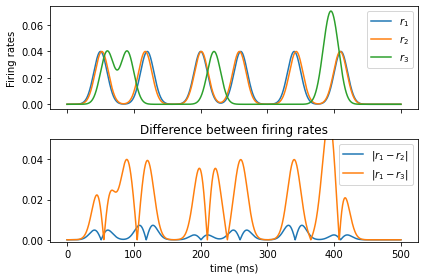

In [12]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)
ax1.plot(t, r   , label='$r_1$')
ax1.plot(t, r2  , label='$r_2$')
ax1.plot(t, r3  , label='$r_3$')
ax1.set_ylabel("Firing rates")
ax1.legend()
ax2.plot(t, np.abs(r - r2),label='$|r_1 - r_2|$')
ax2.plot(t, np.abs(r - r3),label='$|r_1 - r_3|$')
ax2.set_title("Difference between firing rates")
ax2.set_xlabel("time (ms)")
ax2.set_ylim((-0.001,0.05))
ax2.legend()
fig.tight_layout()
plt.show()

Despite different spike trains, the firing rates $r_1$ and $r_2$ are **almost identical**.

However, $r_1$ and $r_3$ are sufficiently different that they can be distinguished by their firing rates.

---

## 10. Conceptual conclusion

This notebook demonstrates explicitly that:

> **Temporal coarse‑graining is irreversible.**

Convolution destroys:

- precise spike timing
- high‑frequency structure
- uniqueness of the microscopic state

This is **why firing‑rate and Wilson–Cowan models cannot (and should not) be inverted** to recover spikes.

---

## Take‑home message

> *A firing rate is not a blurred spike train — it is a new macroscopic variable obtained by irreversible information loss.*

This failure is not a bug.
It is the foundation of population‑level neural theories.